In [5]:
from cobra.io import load_model
from cobra.sampling import sample
import scipy
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
from cobra.flux_analysis import flux_variability_analysis
import cobra
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
from matplotlib.pyplot import figure

In [6]:

krebs_reactions = ["SUCOAS", "AKGDH", "ICDHyr", "ICL", "CS", "MDH", "FUM"]
# Sample data for Pheflux-TIC, Flux Sampling, FVA Loopless, and Experimental fluxes
# Replace these with your actual flux values
exp01 = {'SUCOAS': 59.0944, 'AKGDH': 59.0944, 'ICDHyr': 65.8611, 'ICL': 33.8222,
    'CS': 92.3, 'MDH': 99.4722, 'FUM': 83.6112} # Growth rate 0.1
for reaction,flux in exp01.items():
    exp01[reaction]=exp01[reaction]/100*1.46222


exp02 = {'SUCOAS': 48.8333, 'AKGDH': 48.8333, 'ICDHyr': 52.7444, 'ICL': 30.0833,
    'CS': 82.6611, 'MDH': 89.1333, 'FUM': 73.6889}  # Growth rate 0.2
for reaction,flux in exp02.items():
    exp02[reaction]=exp02[reaction]/100*2.83222

In [7]:
fs = pd.read_csv('../figs2_3/ecoli_iJO1366/sampled_flux_distributions.csv',index_col=0)

In [8]:
# Teraflux
all_flux_dataframes = []
for i in range(1000):
    terafluxi = pd.read_csv(  f"./results/teraflux_iJO1366_{i}.fluxes.csv",index_col=0)
    terafluxi_transposed = terafluxi.T
    all_flux_dataframes.append(terafluxi_transposed)
teraflux_g1 = pd.concat(all_flux_dataframes, ignore_index=True)  

In [9]:
# Flux sampling scaled such that glucose consumption is the one reported by Ishii et al.: -1.46222 mmmol/g/h
g1 = pd.Series(np.array(-1.46222/fs["EX_glc__D_e"]))
fs_g1 = fs.mul(g1,axis=0)

In [10]:
# FVA loopless
model = load_model("iJO1366")
for reaction in model.reactions:
    LB, UB = reaction.bounds
    if LB==-1000: LB = -30000
    if UB== 1000: UB = 30000
    reaction.bounds=(LB,UB)
model.reactions.EX_cbl1_e.bounds = (-30000,0)
model.reactions.EX_glc__D_e.bounds = (-1.46222,-1.46222)
fva_g1=flux_variability_analysis(model,krebs_reactions,loopless=True)

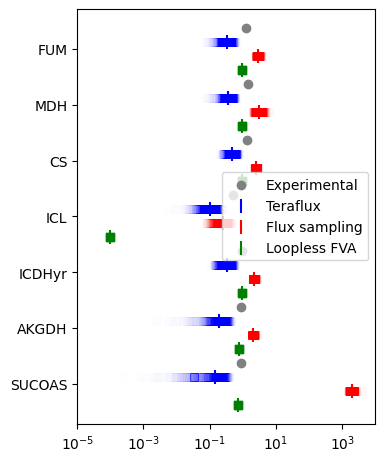

In [11]:
fig = plt.figure()
fig.set_size_inches(5/1.3, 7/1.3)

teraflux_means=[]
for j,reaction in enumerate(krebs_reactions):
    i=j*4
    #data_g1[reaction] = [exp01[reaction], teraflux_g1["R_"+reaction], fs_g1[reaction], fva_g1[reaction] ]

    if i==0:
        plt.scatter(exp01[reaction],i+3,color="grey",label="Experimental")
    else:
        plt.scatter(exp01[reaction],i+3,color="grey")
    
    y = [i+2]*len( teraflux_g1["R_"+reaction] )
    x = abs(teraflux_g1["R_"+reaction])
    plt.scatter(x,y,alpha=0.005,color="blue",marker='s')
    if i==0:
        plt.scatter(np.mean(x),i+2,color="b",marker="|",s=100,label="Teraflux")
    else:
        plt.scatter(np.mean(x),i+2,color="b",marker="|",s=100)
    teraflux_means.append(np.mean(x))

    y = [i+1]*len( fs_g1[reaction] )
    x = abs(fs_g1[reaction])
    plt.scatter(x,y,alpha=0.005,color="red",marker='s')
    if i==0:
        plt.scatter(np.mean(x),i+1,color="r",marker="|",s=100,label="Flux sampling")
    else:
        plt.scatter(np.mean(x),i+1,color="r",marker="|",s=100)

    y = [i]*len( fva_g1.loc[reaction].values )
    x = abs(fva_g1.loc[reaction].values)+1e-4
    plt.scatter(x,y,alpha=1,color="green",marker='s')
    if i==0:
        plt.scatter(np.mean(x),i,color="g",marker="|",s=100,label="Loopless FVA")
    else:
        plt.scatter(np.mean(x),i,color="g",marker="|",s=100)
plt.xscale("log")
plt.legend()
plt.xlim([1e-5,1e4])
plt.yticks([1.5 + i * 4 for i in range(len(krebs_reactions))], krebs_reactions)
plt.savefig("fig4.svg")
plt.show()

In [31]:
scipy.stats.pearsonr(teraflux_means, list(exp01.values()))

PearsonRResult(statistic=np.float64(0.8887796526173268), pvalue=np.float64(0.007456498981731043))